# MRI basis space

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

Attaching package: ‘ggh4x’



    geom_pointpath, GeomPointPath




Do MRI maps cluster together in G1-3 space?

In [19]:
dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
weights = dm_hcp_3d_ds5.weights.iloc[:,:3]
scores = dm_hcp_3d_ds5.clean_scores().set_index('label')

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [6]:
maps = get_maps()

In [82]:
maps

,T1T2,thickness,G1_fMRI,PC1_neurosynth,externopyramidisation,glasser_GI,hill.evo_remapped,hill.dev_remapped,glasser_CBF,allom
label,,,,,,,,,,
V1,1.977036,-2.310289,-0.750526,0.261369,1.769126,-1.523300,-2.446501,-0.275131,2.068603,-1.085134
MST,1.575121,-0.815568,-1.042511,-0.536989,0.630473,-0.392062,0.067569,0.246052,-0.818263,0.965346
V6,1.647248,-1.721457,-1.135492,0.056781,-1.006875,-0.755553,-1.870358,-0.610757,0.396488,-0.020746
V2,1.665496,-2.030079,-0.933047,0.056781,1.377546,-1.113092,-2.070317,-0.614974,1.188173,-1.157744
V3,1.430449,-1.497054,-0.953694,0.056781,1.888340,-0.421922,-1.813154,-0.479010,0.244502,-0.624528
...,...,...,...,...,...,...,...,...,...,...
STSva,-0.795757,0.205376,1.434124,1.234535,1.400205,-0.482769,1.189967,1.170922,-2.081311,0.609727
TE1m,-0.634758,1.084687,1.611986,0.056781,-0.677230,0.461361,1.581797,1.626480,-1.224603,0.906969
PI,-1.391843,-0.240927,-0.607650,0.056781,-1.012710,-1.762716,-0.268852,-2.009474,-2.117425,0.118060


In [101]:
from sklearn.linear_model import LinearRegression

maps_lr_weights = {}
regions = np.intersect1d(scores.index, maps.index)

for m in maps.columns:
    _map = maps[m].loc[regions]
    _lr = LinearRegression().fit(scores.iloc[:,:2], _map)
    maps_lr_weights[m] = pd.Series(_lr.coef_.squeeze())

In [102]:
coefs = pd.concat(maps_lr_weights).unstack(1).set_axis(['G1','G2'],axis=1)
coefs

,G1,G2
T1T2,-0.009047,0.001943
thickness,-0.061738,-0.085822
G1_fMRI,-0.021096,-0.072297
PC1_neurosynth,-0.024855,-0.100596
externopyramidisation,0.071119,-0.001346
glasser_GI,0.005579,0.180733
hill.evo_remapped,-0.131531,0.055760
hill.dev_remapped,0.050462,0.125343
glasser_CBF,-0.051226,0.135424
allom,-0.010654,0.024425


In [103]:
(scores.iloc[:,:2] @ coefs.T).corrwith(maps)

T1T2                    -0.755332
thickness                0.295244
G1_fMRI                 -0.045979
PC1_neurosynth           0.345950
externopyramidisation    0.093721
glasser_GI               0.663992
hill.evo_remapped        0.356713
hill.dev_remapped        0.378405
glasser_CBF              0.227744
allom                    0.132646
dtype: float64

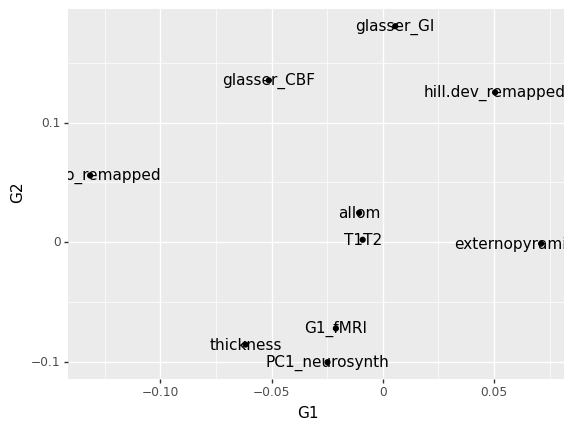

<ggplot: (17591964071991)>

In [104]:
(ggplot(coefs, aes(x='G1',y='G2')) +
geom_point() +
geom_text(aes(label='coefs.index')) )

In [93]:
from sklearn.cross_decomposition import PLSCanonical

maps_pls_weights = {}
regions = np.intersect1d(scores.index, maps.index)

for m in maps.columns:
    _map = maps[m].loc[regions]
    _pls = PLSCanonical(n_components=1).fit(scores.iloc[:,:2], _map)
    maps_pls_weights[m] = pd.Series(_pls.x_weights_.squeeze())

In [97]:
weights = pd.concat(maps_pls_weights).unstack(1).set_axis(['G1','G2'],axis=1)
weights

,G1,G2
T1T2,0.977703,-0.209994
thickness,0.583973,0.811773
G1_fMRI,0.280114,0.959967
PC1_neurosynth,0.239862,0.970807
externopyramidisation,0.999821,-0.018930
glasser_GI,0.030854,0.999524
hill.evo_remapped,0.920684,-0.390308
hill.dev_remapped,0.373464,0.927645
glasser_CBF,-0.353799,0.935322
allom,-0.399825,0.916592


In [ ]:
weights = pd.concat(maps_pls_weights).unstack(1).set_axis(['G1','G2','G3'],axis=1)
weights

,G1,G2,G3
T1T2,0.062580,-0.013441,0.997949
thickness,0.562459,0.781867,-0.268932
G1_fMRI,-0.115198,-0.394791,0.911520
PC1_neurosynth,-0.145637,-0.589443,0.794574
externopyramidisation,-0.306823,0.005809,0.951749
glasser_GI,0.019850,0.643056,0.765562
hill.evo_remapped,0.904244,-0.383338,0.188136
hill.dev_remapped,0.365302,0.907370,0.207926
glasser_CBF,-0.312967,0.827376,0.466369
allom,-0.100509,0.230414,0.967888


Do projections of maps into G space reproduce maps? No

In [98]:
(scores.iloc[:,:2] @ weights.T).corrwith(maps)

T1T2                     0.755332
thickness               -0.295244
G1_fMRI                  0.045980
PC1_neurosynth          -0.345949
externopyramidisation    0.093722
glasser_GI               0.663992
hill.evo_remapped       -0.356714
hill.dev_remapped        0.378405
glasser_CBF              0.227744
allom                    0.132646
dtype: float64

In [ ]:
(scores @ weights.T).corrwith(maps)

T1T2                     0.322735
thickness               -0.257639
G1_fMRI                 -0.293591
PC1_neurosynth           0.018137
externopyramidisation   -0.180043
glasser_GI               0.287803
hill.evo_remapped       -0.409364
hill.dev_remapped        0.347922
glasser_CBF              0.247020
allom                   -0.249230
dtype: float64

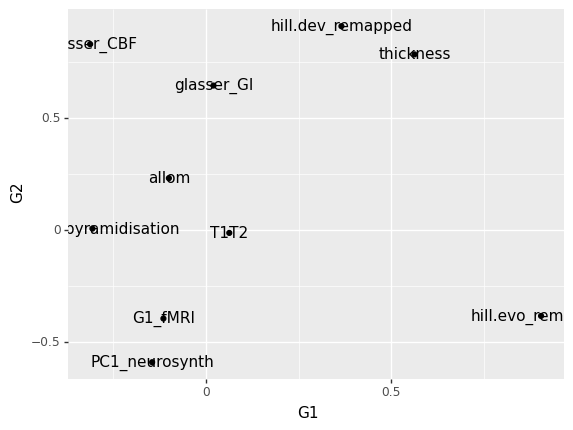

<ggplot: (17591964012253)>

In [90]:
(ggplot(weights, aes(x='G1',y='G2')) +
geom_point() +
geom_text(aes(label='weights.index')) )

In [55]:
maps_corrs = {}
for m in maps.columns:
    _map = maps[m].loc[regions]
    _corrs = scores.join(maps[m]).corr().iloc[:3,3]
    maps_corrs[m] = pd.Series(_corrs)

In [67]:
corrs = pd.concat(maps_corrs).unstack(1)
corrs

,G1,G2,G3
T1T2,0.737281,-0.164245,0.274953
thickness,-0.675986,0.122588,-0.099384
G1_fMRI,-0.380917,0.159047,-0.301345
PC1_neurosynth,-0.233337,-0.298700,-0.241529
externopyramidisation,0.082977,-0.568388,-0.158952
glasser_GI,0.178864,0.658787,-0.182068
hill.evo_remapped,-0.197428,0.448224,-0.313713
hill.dev_remapped,-0.076461,0.438703,-0.106831
glasser_CBF,0.318047,0.363798,0.097691
allom,0.161540,0.215181,-0.291950


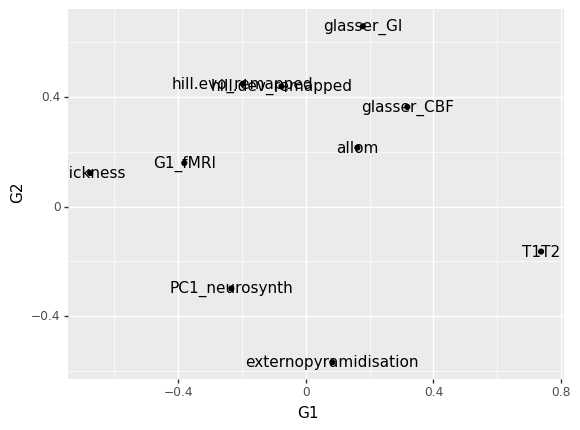

<ggplot: (17591964034838)>

In [92]:
(ggplot(corrs, aes(x='G1',y='G2')) +
geom_point() +
geom_text(aes(label='corrs.index')) )

In [79]:
from plotnine import *
scatter = weights.stack().rename('pls').to_frame().join(corrs.stack().rename('corrs'))
scatter.corr()
# ggplot(scatter) + geom_point(aes('pls','corrs'))

,pls,corrs
pls,1.000000,-0.031304
corrs,-0.031304,1.000000


Do MRI network clusters look like G1, G2?

In [ ]:
# !pip install python-louvain

In [ ]:
import networkx as nx
from community import community_louvain

In [143]:
# maps = get_maps(filter=False).drop(['x','y','z','geodist','curvature', 'PC1_AHBA'],axis=1)
maps = get_maps()

In [144]:
edges = maps.corr() \
        .stack().reset_index() \
        .set_axis(['x','y','r'],axis=1) \
        .assign(weight = lambda x: x['r'].abs())

In [152]:
G=nx.from_pandas_edgelist(edges, 'x', 'y', 'weight')
partition = community_louvain.best_partition(G, resolution=.8)

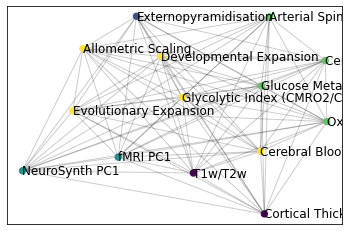

In [153]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, horizontalalignment='left');

In [154]:
edges = edges.assign(x_module = lambda x: x['x'].map(partition)) \
             .assign(y_module = lambda x: x['y'].map(partition))

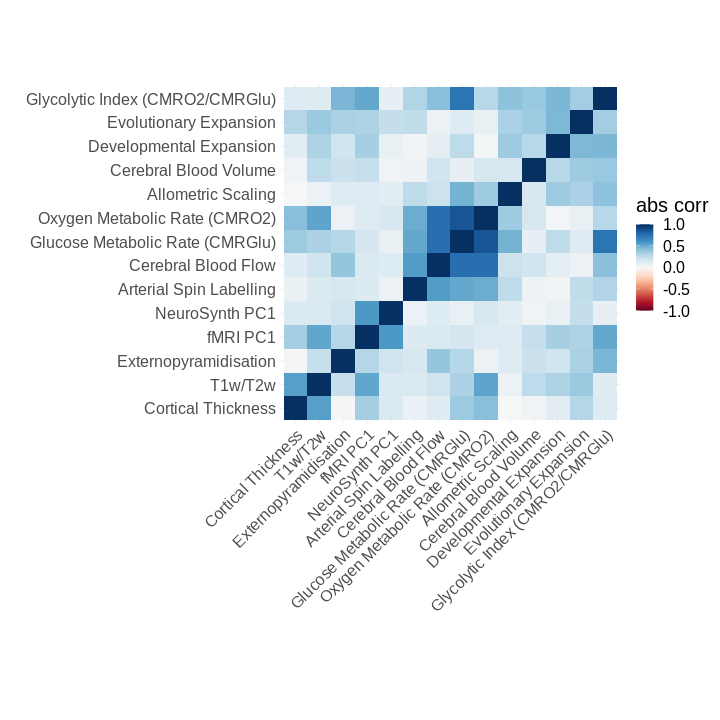

In [162]:
%%R -i edges -w 10 -h 10 --units in
ggplot(edges) + 
geom_raster(aes(reorder(x, x_module),reorder(y, y_module),fill=weight)) +
scale_fill_gradientn(colors=brewer.rdbu(100), limits=c(-1,1), name='abs corr') +
xlab('') + ylab('') +
theme_minimal() +
theme(aspect.ratio=1,
      text=element_text(size=20),
      axis.text.x=element_text(angle=45,hjust=1)
     )

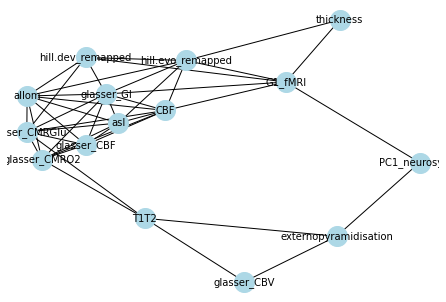

In [57]:
edges_clean = edges \
        .loc[lambda x: x['x']!=x['y']] \
        .loc[lambda x: x['r']>=.2]

G.clear()

G.add_nodes_from(maps.columns)

G=nx.from_pandas_edgelist(edges_clean, 'x', 'y', ['r'])
nx.draw(G, with_labels=True, node_color='lightblue', node_size=400, edge_color='black', linewidths=1, font_size=10)

In [53]:
G['T1T2']['externopyramidisation']#['weight']

{'r': 0.23372648043491284}